In [18]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from difflib import SequenceMatcher

In [2]:
# Function to load all service JSON files
def load_service_files(services_dir):
    services_data = {}
    for filename in os.listdir(services_dir):
        if filename.endswith('.json'):
            filepath = os.path.join(services_dir, filename)
            with open(filepath, 'r') as f:
                service_data = json.load(f)
                service_name = service_data.get('service_name', os.path.splitext(filename)[0])
                services_data[service_name] = service_data
    return services_data

# Function to extract all method names across services
def extract_method_names(services_data):
    all_methods = []
    service_methods = {}
    
    for service_name, service_data in services_data.items():
        if 'client' in service_data and 'methods_names' in service_data['client']:
            methods = service_data['client']['methods_names']
            all_methods.extend(methods)
            service_methods[service_name] = methods
    
    return all_methods, service_methods

In [ ]:
def analyze_method_uniqueness(all_methods):
    method_counts = Counter(all_methods)
    
    unique_methods = {method: count for method, count in method_counts.items() if count == 1}
    repeated_methods = {method: count for method, count in method_counts.items() if count > 1}
    
    return unique_methods, repeated_methods

# Function to find methods with similar names
def find_similar_methods(all_methods, threshold=0.8):
    """Find methods with similar names, with optimization."""
    similar_methods = []
    processed = set()
    method_list = list(all_methods)  # Convert to list if it isn't already
    
    # Early filtering: group methods by first character and length
    # This avoids comparing methods that are guaranteed to be too different
    method_groups = {}
    for method in method_list:
        # Group by first character and approximate length
        first_char = method[0] if method else ""
        length_group = len(method) // 3  # Methods with very different lengths won't be similar
        key = (first_char, length_group)
        
        if key not in method_groups:
            method_groups[key] = []
        method_groups[key].append(method)
    
    # Process each group separately
    for group_methods in method_groups.values():
        # Skip tiny groups
        if len(group_methods) < 2:
            continue
            
        for i, method1 in enumerate(group_methods):
            if method1 in processed:
                continue
                
            similar_group = [method1]
            processed.add(method1)
            
            # Quick length check before doing expensive similarity calculation
            method1_len = len(method1)
            
            for method2 in group_methods[i+1:]:
                if method2 in processed:
                    continue
                    
                # Skip if length difference guarantees dissimilarity
                method2_len = len(method2)
                if abs(method1_len - method2_len) / max(method1_len, method2_len) > (1 - threshold):
                    continue
                
                # Calculate similarity ratio
                # Using SequenceMatcher for string similarity
                similarity = SequenceMatcher(None, method1, method2).ratio()
                if similarity >= threshold and method1 != method2:
                    similar_group.append(method2)
                    processed.add(method2)
            
            if len(similar_group) > 1:
                similar_methods.append(similar_group)
    
    return similar_methods

In [4]:
# Function to extract action verbs from method names
def extract_action_verbs(all_methods):
    """Extract action verbs from method names by splitting at the first underscore"""
    action_verbs = []
    
    for method in all_methods:
        # Split at the first underscore
        parts = method.split('_', 1)
        if len(parts) > 0:
            action = parts[0].lower()
            action_verbs.append(action)
        else:
            # Fallback for methods without underscores
            action_verbs.append(method.lower())
    
    return action_verbs

In [ ]:
# Function to plot the statistics
def plot_method_uniqueness(unique_methods, repeated_methods):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Unique vs Repeated Methods
    counts = [len(unique_methods), len(repeated_methods)]
    labels = ['Unique Methods', 'Repeated Methods']
    ax1.bar(labels, counts, color=['#5DA5DA', '#FAA43A'])
    ax1.set_title('Unique vs. Repeated Methods Across Services')
    ax1.set_ylabel('Count')
    
    for i, count in enumerate(counts):
        ax1.text(i, count + 5, str(count), ha='center')
    
    # Plot 2: Distribution of repeated methods
    if repeated_methods:
        repeat_counts = list(repeated_methods.values())
        
        # Filter out extreme outliers for better visualization
        # Let's use the 95th percentile as a cutoff
        percentile_95 = np.percentile(repeat_counts, 95)
        max_bin = min(int(percentile_95) + 5, 20)  # Cap at 20 for readability
        
        # Create bins with more granularity in the lower range
        bins = list(range(2, max_bin + 1))
        
        # Plot histogram with adjusted bins
        sns.histplot(repeat_counts, bins=bins, kde=False, ax=ax2, color='#FAA43A')
        
        # Add an annotation for values beyond our display range
        outliers = sum(1 for count in repeat_counts if count > max_bin)
        if outliers > 0:
            ax2.text(0.95, 0.95, f"{outliers} methods with >{max_bin} repetitions", 
                    transform=ax2.transAxes, ha='right', va='top', 
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))
        
        ax2.set_title('Distribution of Method Repetition')
        ax2.set_xlabel('Number of Repetitions')
        ax2.set_ylabel('Count of Methods')
        
        # Ensure x-axis starts at 2 (minimum repetition count)
        ax2.set_xlim(left=1.5)
    else:
        ax2.text(0.5, 0.5, "No repeated methods found", ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the top repeated methods
def plot_top_repeated_methods(repeated_methods, top_n=20):
    if not repeated_methods:
        print("No repeated methods to plot.")
        return
        
    # Sort methods by repetition count (descending)
    sorted_methods = sorted(repeated_methods.items(), key=lambda x: x[1], reverse=True)
    
    # Take the top N methods
    top_methods = sorted_methods[:top_n]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Extract method names and counts
    method_names = [method for method, _ in top_methods]
    method_counts = [count for _, count in top_methods]
    
    # Create horizontal bar chart
    bars = plt.barh(method_names, method_counts, color='#60BD68')
    
    # Add labels
    plt.xlabel('Number of Repetitions')
    plt.ylabel('Method Name')
    plt.title(f'Top {len(top_methods)} Most Repeated Methods Across Services')
    
    # Add count labels to the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                str(method_counts[i]), va='center')
    
    plt.tight_layout()
    plt.show()

# Function to plot action verbs distribution
def plot_action_verbs(action_verbs, top_n=20):
    verb_counts = Counter(action_verbs)
    
    # Get the top N action verbs
    top_verbs = verb_counts.most_common(top_n)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Extract verb names and counts
    verb_names = [verb for verb, _ in top_verbs]
    verb_counts = [count for _, count in top_verbs]
    
    # Create horizontal bar chart
    bars = plt.barh(verb_names, verb_counts, color='#F15854')
    
    # Add labels
    plt.xlabel('Count')
    plt.ylabel('Action Verb')
    plt.title(f'Top {len(top_verbs)} Most Common Action Verbs in Method Names')
    
    # Add count labels to the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                str(verb_counts[i]), va='center')
    
    plt.tight_layout()
    plt.show()

# Function to plot service comparison by action verb usage
def plot_service_verb_comparison(service_methods, top_verbs=5, top_services=10):
    # Extract verbs for each service
    service_verbs = {}
    for service, methods in service_methods.items():
        service_verbs[service] = Counter(extract_action_verbs(methods))
    
    # Find the top verbs across all services
    all_verbs = Counter()
    for verbs in service_verbs.values():
        all_verbs.update(verbs)
    top_common_verbs = [verb for verb, _ in all_verbs.most_common(top_verbs)]
    
    # Create a DataFrame for plotting
    data = []
    for service, verbs in service_verbs.items():
        for verb in top_common_verbs:
            data.append({
                'Service': service,
                'Verb': verb,
                'Count': verbs.get(verb, 0)
            })
    
    df = pd.DataFrame(data)
    
    # Get top services by total method count
    service_method_counts = {service: len(methods) for service, methods in service_methods.items()}
    top_services_list = sorted(service_method_counts.items(), key=lambda x: x[1], reverse=True)[:top_services]
    top_services_names = [service for service, _ in top_services_list]
    
    # Filter DataFrame for top services
    df_filtered = df[df['Service'].isin(top_services_names)]
    
    # Create a pivot table
    pivot_df = df_filtered.pivot(index='Service', columns='Verb', values='Count').fillna(0)
    pivot_df = pivot_df.reindex(top_services_names)
    
    # Plot
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_df, annot=True, fmt='g', cmap='YlGnBu')
    plt.title(f'Top {top_verbs} Action Verbs Usage in Top {top_services} Services')
    plt.tight_layout()
    plt.show()

# Function to save all unique action verbs to a file
def save_action_verbs_list(action_verbs):
    # Get unique action verbs and sort them
    unique_verbs = sorted(set(action_verbs))
    
    # Save to file
    with open('./unique_action_verbs.txt', 'w') as f:
        for verb in unique_verbs:
            f.write(f"{verb}\n")
    
    print(f"Saved {len(unique_verbs)} unique action verbs to 'unique_action_verbs.txt'")


In [6]:
services_dir='./parsing/services'

services_data = load_service_files(services_dir)
print(f"Loaded {len(services_data)} service files")

Loaded 401 service files


In [7]:
# Extract method names
all_methods, service_methods = extract_method_names(services_data)
print(f"Found {len(all_methods)} methods across all services")

Found 18157 methods across all services


In [8]:
# Analyze method uniqueness
unique_methods, repeated_methods = analyze_method_uniqueness(all_methods)
print(f"Unique methods: {len(unique_methods)}")
print(f"Repeated methods: {len(repeated_methods)}")

Unique methods: 11536
Repeated methods: 1391


In [11]:
# Find similar methods
similar_methods = find_similar_methods(all_methods)
print(f"Found {len(similar_methods)} groups of similar methods")

Found 1734 groups of similar methods


In [12]:
# Extract action verbs
action_verbs = extract_action_verbs(all_methods)

In [13]:
# Save list of unique action verbs
save_action_verbs_list(action_verbs)

Saved 267 unique action verbs to 'unique_action_verbs.txt'


c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


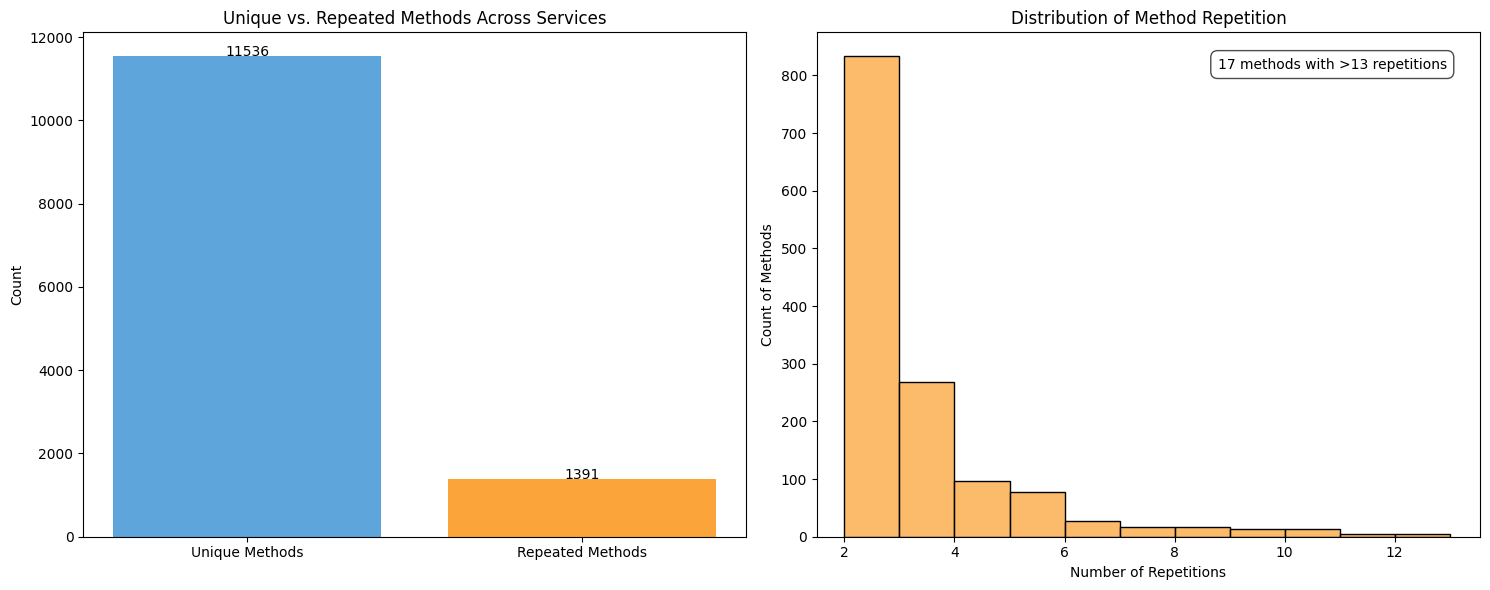

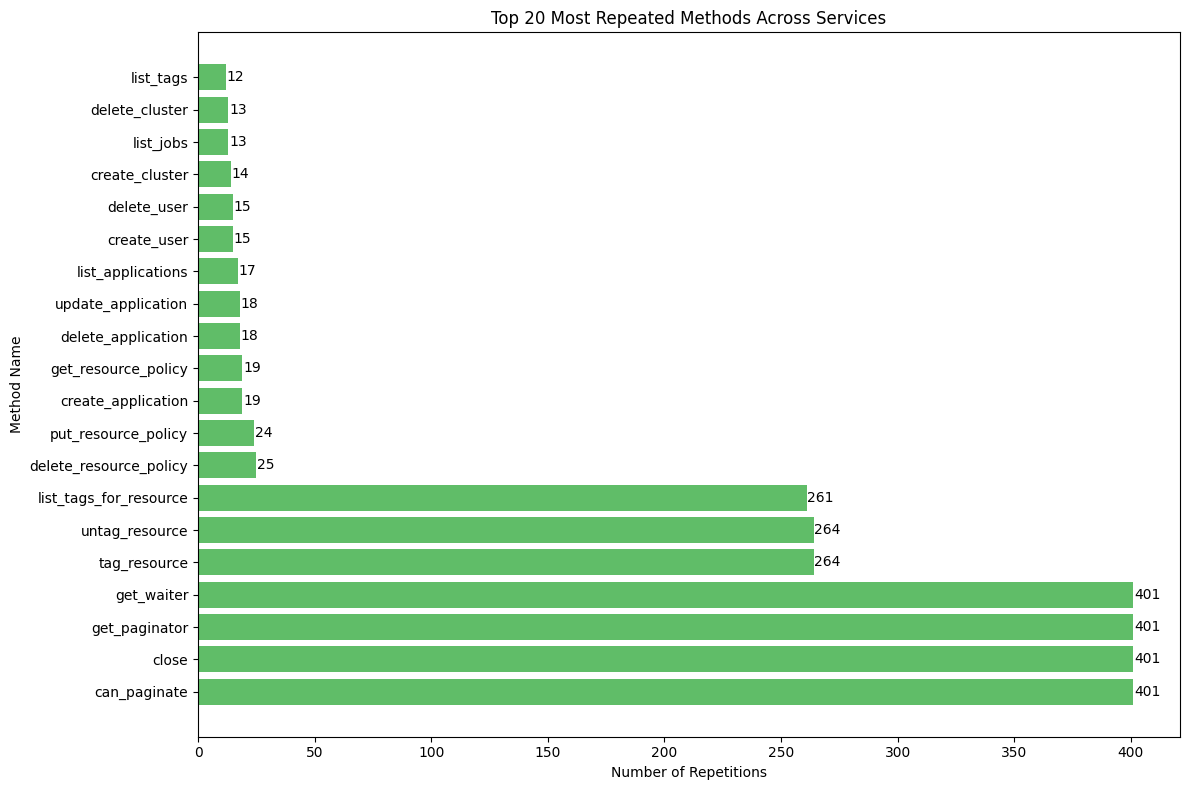

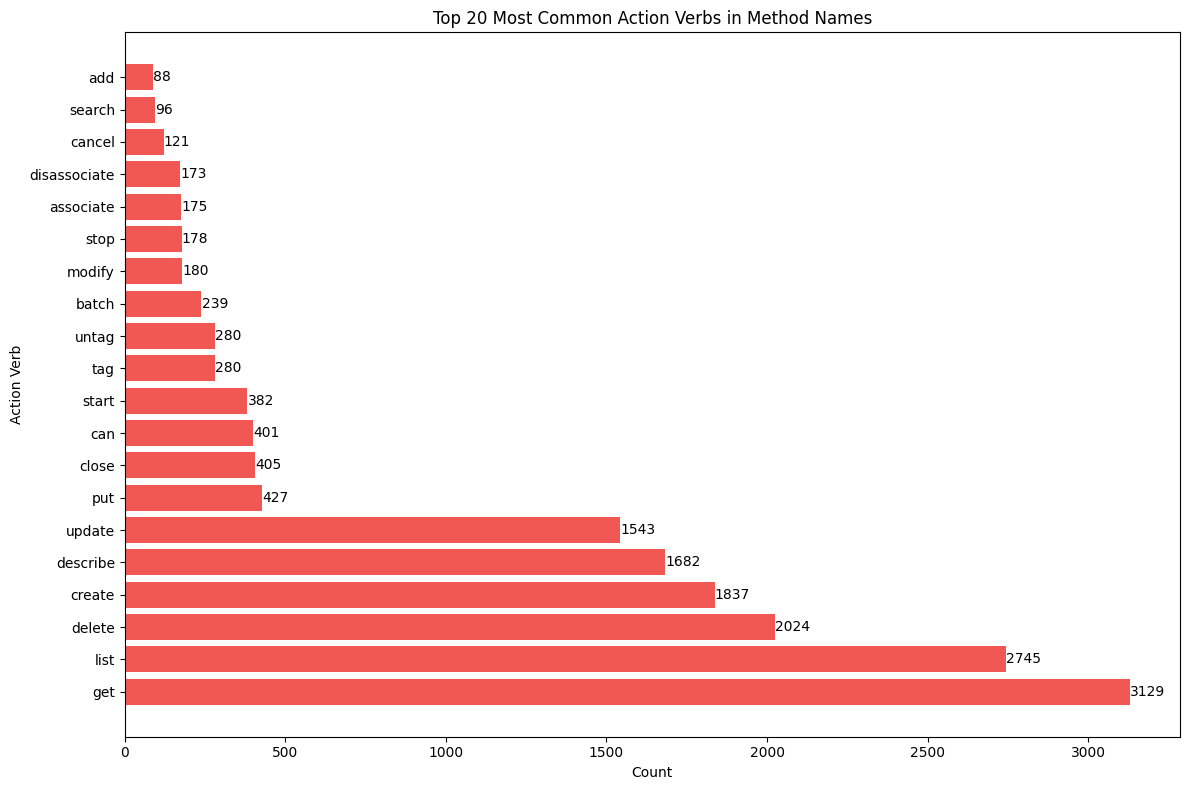

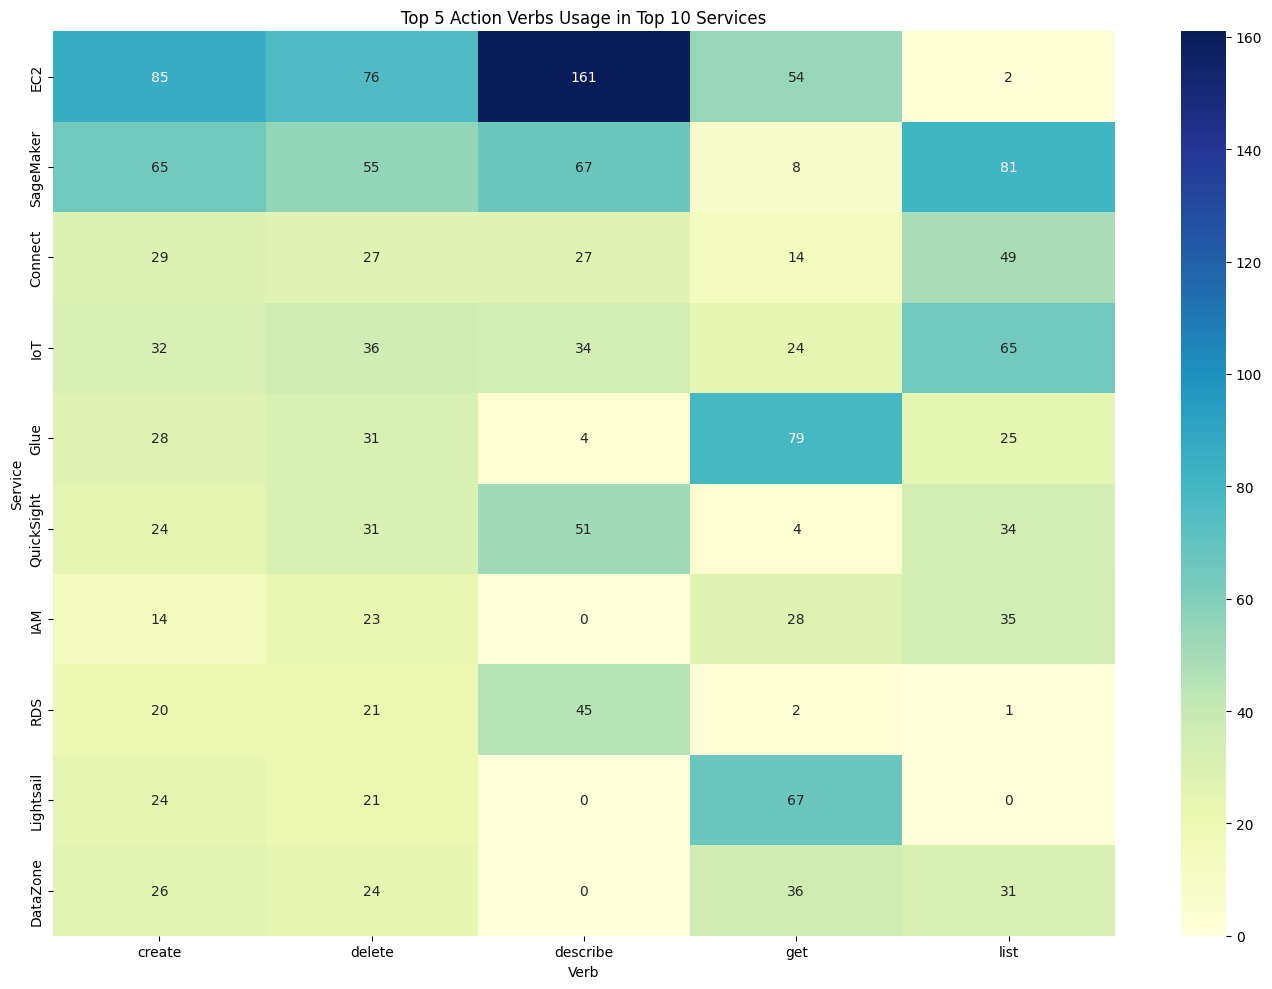

In [31]:
# Generate plots
plot_method_uniqueness(unique_methods, repeated_methods)
plot_top_repeated_methods(repeated_methods)
plot_action_verbs(action_verbs)
plot_service_verb_comparison(service_methods)

In [15]:
# Print some example similar methods
if similar_methods:
    print("\nExample groups of similar methods:")
    for i, group in enumerate(similar_methods[:5]):
        print(f"Group {i+1}: {', '.join(group)}")


Example groups of similar methods:
Group 1: attach_group_policy, attach_role_policy, attach_user_policy
Group 2: create_agent, create_stage, create_budget, create_facet, create_segment, create_asset, create_image, create_entity, create_grant, create_intent, create_alert
Group 3: create_prompt, create_route, create_project, create_probe, create_group, create_program, create_robot, create_product
Group 4: create_branch, create_launch, create_graph, create_brand
Group 5: create_backend, create_backup, create_bucket
